<font color=skyblue>Read and show an image</font>

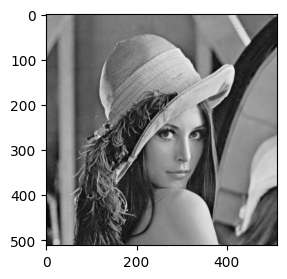

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
# from skimage import io

imgfile = "pictures/Lenna.png" # 512x512x3
X = mpimg.imread(imgfile)
if len(X.shape) > 2:
    X = np.mean(X, axis=2) # convert RGB to grayscale
# X = io.imread(imgfile, as_gray = True)
fig = plt.figure(figsize=(3, 3))
plt.imshow(X, cmap = 'gray')
plt.show()

<hr>
<font color=yellow>利用 Rank q approximation 做影像壓縮</font>

即 $X_q = U_qU_q^TX$

$q$ 的大小決定壓縮倍數，壓縮倍數越大，影像品質越差
<hr>

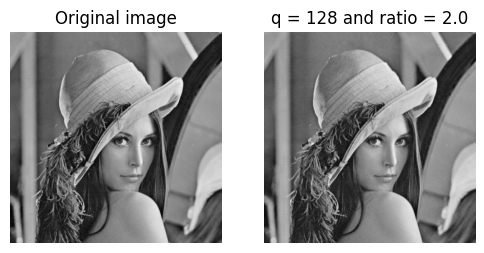

The compression ratio is 2.0


In [11]:
from scipy.linalg import svd

U, E, VT = svd(X, full_matrices = False)
q = 128
Xq = U[:, :q] @ np.diag(E[:q]) @ VT[:q, :]

fig = plt.figure(figsize=(6, 3))
plt.subplot(121)
plt.imshow(X, cmap = 'gray')
plt.axis('off')
plt.title("Original image")
plt.subplot(122)
plt.imshow(Xq, cmap = 'gray')
Ratio = q * (U.shape[0] + VT.shape[1]) / (U.shape[0] * VT.shape[1])
# plt.title(f"Compressed image with q = {q} and compression ratio = {1/Ratio:.1f}")
# plt.title(f"Compressed image with q = {q}")
plt.title(f"q = {q} and ratio = {1/Ratio:.1f}") 
plt.axis('off')
plt.show()
print("The compression ratio is",  1/Ratio)

<font color=yellow>比較不同壓縮比例的影像品質</font>

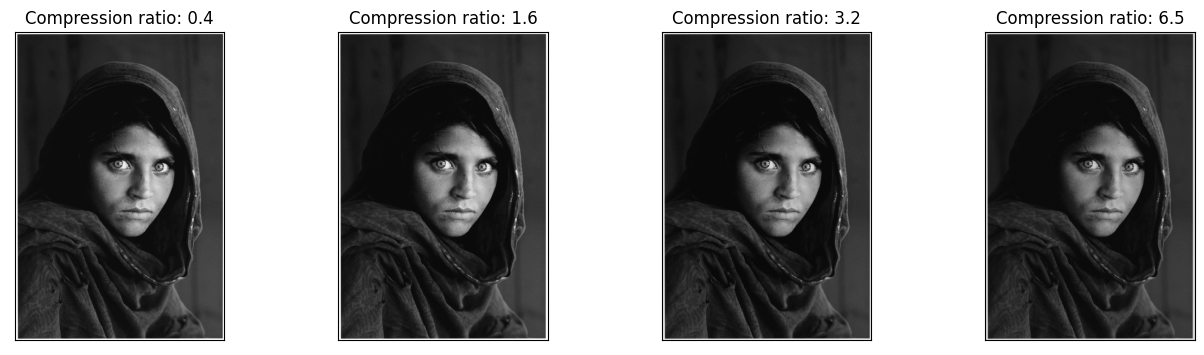

In [22]:
import numpy as np
from numpy.linalg import svd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# imgfile = "pictures/Lenna.png" # 512x512x3
imgfile = "pictures/afghan_girl_large.jpg" # 512x512x3
X = mpimg.imread(imgfile)
if len(X.shape) > 2:
    X = np.mean(X, axis=2) # convert RGB to grayscale

p, N = X.shape # p by N, p = 512, N = 512
U, E, VT = svd(X, full_matrices = False)
q = np.array([p, p/4, p/8, p/16]).astype('int')
# q = np.array([512, 200, 100, 50]).astype('int') 
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
for i, r in enumerate(q):
    Xq = U[:, :r] @ np.diag(E[:r]) @ VT[:r, :] 
    ax[i].imshow(Xq, cmap = 'gray')
    ratio = p * N / (U.shape[0] + VT.shape[1] + 1) / r # compression ratio
    ax[i].set_title('Compression ratio: {:.1f}'.format(ratio))
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.show()

<font color=yellow>利用 Truncated SVD 做影像壓縮</font>

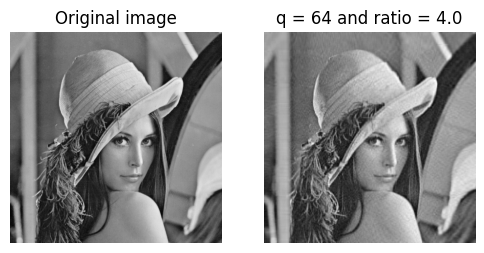

In [16]:
from sklearn.decomposition import TruncatedSVD

q = 64
svd = TruncatedSVD(n_components = q, random_state = 0)
Zq = svd.fit_transform(X) # compress Uq.TX
Xq = svd.inverse_transform(Zq) # decompress UqUq.TX

fig = plt.figure(figsize=(6, 3))

plt.subplot(121)
plt.imshow(X, cmap = 'gray')
plt.axis('off')
plt.title("Original image")

plt.subplot(122)
plt.imshow(Xq, cmap = 'gray')
Ratio = q * (U.shape[0] + VT.shape[1]) / (U.shape[0] * VT.shape[1])
plt.title(f"q = {q} and ratio = {1/Ratio:.1f}")
plt.axis('off')
plt.show()

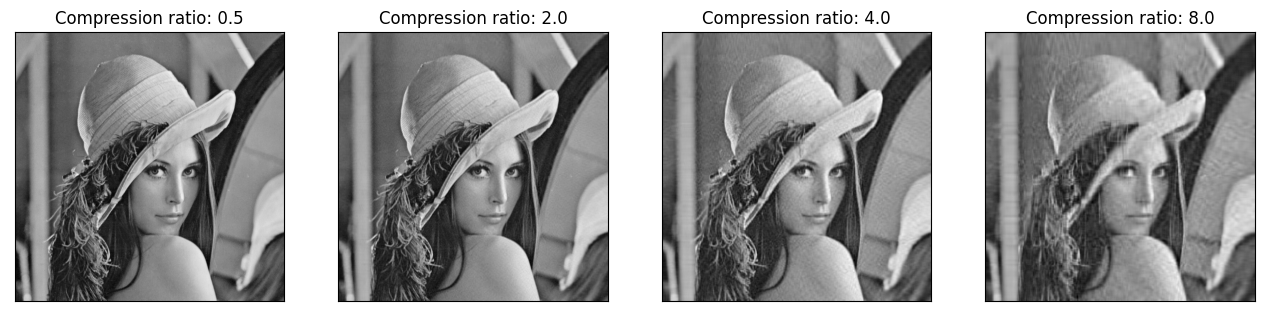

In [18]:
import numpy as np
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

imgfile = "pictures/Lenna.png" # 512x512x3
X = mpimg.imread(imgfile)
if len(X.shape) > 2:
    X = np.mean(X, axis=2) # convert RGB to grayscale

p, N = X.shape # p by N, p = 512, N = 512
q = np.array([p, p/4, p/8, p/16]).astype('int')

fig, ax = plt.subplots(1, 4, figsize=(16, 4))
for i, r in enumerate(q):
    svd = TruncatedSVD(n_components = r, random_state = 0)
    Zq = svd.fit_transform(X) # compress
    Xq = svd.inverse_transform(Zq) # decompress
    ax[i].imshow(Xq, cmap = 'gray')
    ratio = p * N / (U.shape[0] + VT.shape[1] + 1) / r # compression ratio
    ax[i].set_title('Compression ratio: {:.1f}'.format(ratio))
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.show()

In [40]:
import numpy as np

def montage(A, m, n):
    '''
    Create a montage matrix with mn images
    Inputs:
    A: original pxN image matrix with N images (p pixels), N > mn
    m, n: m rows & n columns, total mn images
    Output:
    M: montage matrix containing mn images  
    '''

    sz = np.sqrt(A.shape[0]).astype('int') # image size sz x sz
    M = np.zeros((m*sz, n*sz)) # montage image
    for i in range(m) :
        for j in range(n) :
            M[i*sz: (i+1)*sz, j*sz:(j+1)*sz] = \
            A[:, i*n+j].reshape(sz, sz)
    return M

<font color=yellow>Patch-based SVD: preliminary work</font>

- 將一張影像切割成 $s \times s$ 的 patch，然後將每個 patch 拉成向量組合成新的矩陣 M。
- 再將 M 重組回到原來的影像。

Total number of patches: 1024
Size of each patch: 256


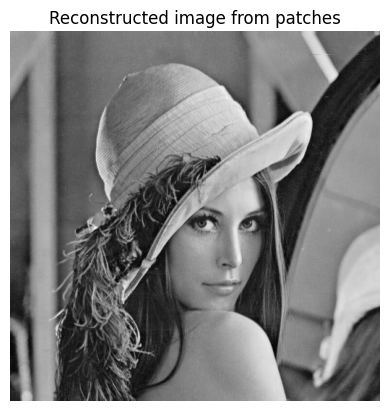

In [43]:
# use skimage.util.view_as_blocks to get patches
from skimage.util import view_as_blocks

imgfile = "pictures/Lenna.png" # 512x512x3
X = mpimg.imread(imgfile)
if len(X.shape) > 2:
    X = np.mean(X, axis=2) # convert RGB to grayscale

patch_size = 16
patches = view_as_blocks(X, block_shape=(patch_size, patch_size))
M = patches.reshape(-1, patch_size * patch_size) # flatten the patches

print("Total number of patches:", M.shape[0])
print("Size of each patch:", M.shape[1])
# 將 M 重組回到 X 的形狀
X_reconstructed = montage(M.T, patches.shape[0], patches.shape[1]) # 
# X_reconstructed = M.reshape(X.shape[0] // patch_size, X.shape[1] // patch_size, patch_size, patch_size)
# X_reconstructed = X_reconstructed.transpose(0, 2, 1, 3).reshape(X.shape[0], X.shape[1])
plt.imshow(X_reconstructed, cmap='gray')
plt.title("Reconstructed image from patches")
plt.axis('off')
plt.show()
